In [1]:
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat, umath, unumpy
from math import log10, floor
import scipy.optimize as opt

In [2]:
# Settings + Notes
"""The units used are in SI units."""

# Plotting Settings
plt.style.use("default")

# # remove interactive mode
# plt.ioff()

# # disable images from automatically showing up
# use("Agg")

# Exporting Saved Images
def export_plot(plot, filename, savelocation="../exports/", _quality=95, _dpi=100, _optimize=True):
    """Saves a plot to the specified location."""
    plot.savefig(str(savelocation + filename), quality=_quality, dpi=_dpi, optimize=_optimize)

# Import data
def import_data(filename, savelocation="../data/labview/", delimiter="\t", skipRows=2):
    # print(filename)
    data = np.genfromtxt(savelocation+filename, delimiter=delimiter, skip_header=skipRows)
    # print(data)
    return data

In [3]:
# Equations
def mean(array):
    return sum(array)/len(array)

def standard_deviation(array):
    numerator = 0
    arrayMean = mean(array)
    N = len(array)
    for i in range(N):
        numerator += umath.pow((array[i] - arrayMean), 2)
    return umath.pow((numerator/N), 1/2)

def convert_to_ufloat(data, uncert):
    if not isinstance(data, (list, tuple, set)):
        return ufloat(data, uncert)
    return [ufloat(e, uncert) for e in data]

def seperate_ufloat(data):
    if not isinstance(data, (list, tuple, set)):
        return data.nominal_value, data.std_dev
    nominals, devs = [], []
    for e in data:
        nominals.append(e.nominal_value)
        devs.append(e.std_dev)
    return nominals, devs

def chi_squared(dataX, dataY, f):
    chi2 = 0
    for i in range(len(dataX)):
        collected = dataY[i]
        actual = f(dataX[i])
        chi2 = (umath.pow(actual - collected, 2))/actual
    return chi2

def coeff_of_determination(dataX, dataY, func):
    N = len(dataX)
    yBar = mean(dataY)
    SS_tot = [umath.pow((e - yBar), 2) for e in dataY]
    SS_reg = [umath.pow((func(dataX[i]) - yBar), 2) for i in range(N)]
    SS_res = [umath.pow((dataY[i] - func(dataX[i])), 2) for i in range(N)]
    return 1 - sum(SS_res)/sum(SS_tot)

def round_sig(x, sig=1):
    return round(x, sig-int(floor(log10(abs(x))))-1)

def volume_sphere(R):
    return (4/3) * np.pi * pow(R, 3)

def calculate_tau(m, r, eta):
    return m/(6 * np.pi * r * eta)

def reynolds_number(rho, l, v, eta):
    return rho * l * v/eta

def vcorrected(vm, d):
    d2 = d/UPPER_D
    denom = 1 - 2.104*d2 + 2.089*(d2**2)
    return vm/denom

In [4]:
# Constants
G = ufloat(9.81, 0.03)  # the gravitational acceleration measured at UofT MP: https://faraday.physics.utoronto.ca/PVB/Harrison/ErrorAnalysis/Introduction.html

UNCERTAINTY_CALIPER = 0.05  # cm
UNCERTAINTY_CALIPER *= 10  # mm 

UNCERTAINTY_POS = 0.0005  # mm

UNCERTAINTY_TIME = 0.005 # s from digital

INDEX_TIME = 0 # seconds
INDEX_POS = 1  # mm

BEAD_SIZES = [0.11, 0.21, 0.31, 0.49, 0.6]
BEAD_SIZES = convert_to_ufloat([e*10 for e in BEAD_SIZES], UNCERTAINTY_CALIPER)

DENSITY_GLY = 1.26  # g/cm^3
VISCOTIY_GLY = 9.34  # g/(cm*s)
DENSITY_H20 = 1  # g/cm^3
VISCOSITY_H20 = 1/100  # g/(cm*s)
DESNITY_TEFLON = 2.2  # g/cm^3
DENSITY_NYLON = 1.12  # g/cm^3

UPPER_D = convert_to_ufloat((9.2)*10, UNCERTAINTY_CALIPER)  # mm 

In [5]:
# Numerical Exercise
# givens
r = 0.5 * pow(10, -3)  # m 
n = 1500 * pow(10, -2)  # Poise
p = 2.7 # g/cm^3



# # tau = calculate_tau()



# print("Tau is: {}[s]".format(tau))

Slope: 3.14+/-0.05 [m/s]
a is: 1.2857161916597377+/-[[0.04368532]]
Rens: [0.009410181780975744+/-0.004385944243349376, 0.04047675462302721+/-0.010102505824181715, 0.10572740637006323+/-0.018266685882669303, 0.3710429898736819+/-0.04212890499851353, 0.7745402901704234+/-0.07352130872743218]
table: [3.224280692143391+/-0.05565879046918341, 3.2040076795233565+/-0.05128831132609515, 3.0837352034753995+/-0.04471605706803002]
terminals ex1: {1: 3.1706745250473825+/-0.04665069485714535, 2: 7.143856541554689+/-0.08761347989959965, 3: 12.640731893194962+/-0.14978439205248212, 4: 28.065610021219538+/-0.3377448668607539, 5: 47.84527982931055+/-0.6101075798043165}


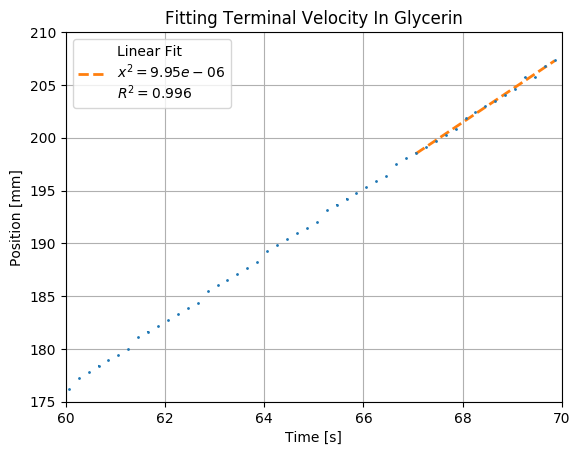

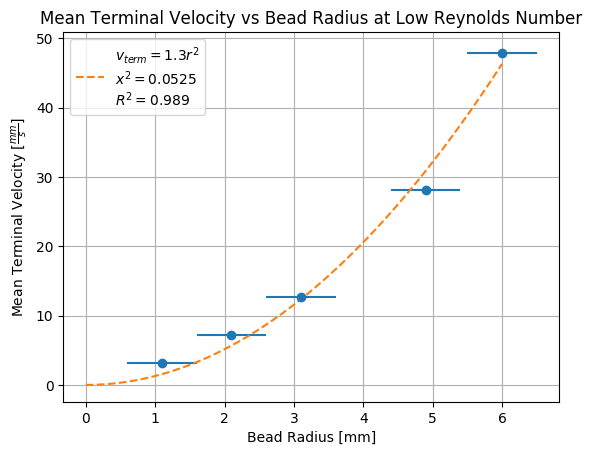

In [6]:
# Ex.1: Low Reynolds Number, Glycerin
# importing
    # file names
files = []
for i in range(1, 6):
    filePrefix = "gg"+str(i)+"-t"
    for j in range(1, 4):
        file = filePrefix + str(j)+".txt"
        files.append(file)
    
    # import files
data = {}
for file in files:
    # print(file)
    key = file[:-4]
    npdata = import_data(file)
    while npdata[1, INDEX_POS] == 0:
        npdata = np.delete(npdata, 0, 0)
    while npdata[-1, INDEX_POS] == 0:
        npdata = np.delete(npdata, -1, 0)
    pyData = []
    for rows in npdata:  # change to lists with uncerts
        newRow = [convert_to_ufloat(rows[INDEX_TIME], UNCERTAINTY_TIME), convert_to_ufloat(rows[INDEX_POS], UNCERTAINTY_POS)] 
        pyData.append(newRow)
    data[key] = pyData

# fitting + mean terminals
terminals = {}  # avg terminals
dataFits = {}  # slopes (terminal velocities) and intercepts
dig = 1  # 1 to 5
averages = []  # temp-memory array
fromBack = 15  # amount of last points
tableKeep = []
for key, value in data.items():
    interest = value[len(value)-fromBack:len(value)]
    time_nom = [row[INDEX_TIME].nominal_value for row in interest]
    pos_nom = [row[INDEX_POS].nominal_value for row in interest]
    coeffs, cov = np.polyfit(time_nom, pos_nom, deg=1, full=False, cov=True)
    a_uncert = np.sqrt(cov[0,0])  # mm/s
    b_uncert = np.sqrt(cov[1, 1])  # s
    res = [convert_to_ufloat(coeffs[0], a_uncert), convert_to_ufloat(coeffs[1], b_uncert)]
    averages.append(res[0])
    if (dig % 3) == 0 :  # gg[]-..
        terminals[dig//3] = vcorrected(mean(averages), BEAD_SIZES[dig//3 - 1])
        if dig == 3:
            tableKeep = list(averages)
        averages = []
    dig += 1
    dataFits[key] = res



# plotting process
example1 = "gg1-t1"
time_nom = [row[INDEX_TIME].nominal_value for row in data[example1]]
pos_nom = [row[INDEX_POS].nominal_value for row in data[example1]]
time_uncert = [row[INDEX_TIME].std_dev for row in data[example1]]
pos_uncert = [row[INDEX_POS].std_dev for row in data[example1]]
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.grid(True)
ax1.set_title("Fitting Terminal Velocity In Glycerin")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Position [mm]")
ax1.errorbar(time_nom, pos_nom,time_uncert, pos_uncert, "o", markersize=1)

    # fitted
fitCoeffs, fitCoeffs_uncert = seperate_ufloat(dataFits[example1])
p = np.poly1d(fitCoeffs)
min_nom = min(time_nom[len(time_nom)-fromBack:len(time_nom)])
max_nom = max(time_nom[len(time_nom)-fromBack:len(time_nom)])

xMin = 60
xMax = 70
yMin = 175
yMax = 210
ax1.set_xlim([xMin, xMax])
ax1.set_ylim([yMin, yMax])
xp = np.linspace(min_nom, max_nom)
ax1.plot(xp, p(xp), "--", linewidth=2)

x2 = chi_squared(time_nom[len(time_nom)-fromBack:len(time_nom)], pos_nom[len(time_nom)-fromBack:len(time_nom)], p)
r2 = coeff_of_determination(time_nom[len(time_nom)-fromBack:len(time_nom)], pos_nom[len(time_nom)-fromBack:len(time_nom)], p)

ax1.legend(["Linear Fit\n$x^2={}$\n$R^2={}$".format(round_sig(x2, 3), round_sig(r2, 3))])

# print("Chi: {}, R^2: {}".format(round_sig(x2, 3), round_sig(r2, 3)))


print("Slope: {} [m/s]".format(dataFits[example1][0]))

#export
export_plot(fig, "ex1_fitting_terminal_points")
####################################################

# plotting
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(True)
ax.set_title("Mean Terminal Velocity vs Bead Radius at Low Reynolds Number")
ax.set_xlabel("Bead Radius [mm]")
ax.set_ylabel("Mean Terminal Velocity $[\\frac{mm}{s}]$")
    # gen data
bead_nom, bead_uncert = seperate_ufloat(BEAD_SIZES)
v_nom, v_uncert = [], []
for i in terminals:
    e = terminals[i]
    v_nom.append(e.nominal_value)
    v_uncert.append(e.std_dev)
ax.errorbar(bead_nom, v_nom, v_uncert,bead_uncert, "o")  # main plot

    # fitting
def aQuad(x, a):
    return a * x**2
fit, covar = opt.curve_fit(aQuad, bead_nom, v_nom)
p = np.poly1d([fit[0], 0, 0])
xp = np.linspace(0, max(bead_nom))
print("a is: {}+/-{}".format(fit[0], np.sqrt(covar)))

ax.plot(xp, p(xp), "--")  # quadratic fit

x2 = chi_squared(bead_nom, v_nom, p)
r2 = coeff_of_determination(bead_nom, v_nom, p)

ax.legend(["$v_{term}$" +"$ = {}r^2$".format(round_sig(fit[0], 2))+"\n$x^2={}$\n$R^2={}$".format(round_sig(x2, 3), round_sig(r2, 3))])

export_plot(fig, "ex1_mean_vterm_n_beadr")

##
rens = []
for i in range(len(BEAD_SIZES)):
    diam = 2*BEAD_SIZES[i]
    vs = terminals[i+1]
    rens.append(reynolds_number(DENSITY_GLY, diam/10, vs/10, VISCOTIY_GLY))
print("Rens: {}".format(rens))

tableKeep = [vcorrected(e, 1.1) for e in tableKeep]
print("table:", tableKeep)
print("terminals ex1:",terminals)

Slope: 61.47+/-0.23 [m/s]
b is: 61.67223614327233+/-[[1.82872708]]
c is: -11.930982372869963+/-2.4604115711412264
d is: 71.2144852158408+/-6.709718970330154
Rens: [149.60823324162814+/-68.00415716065025, 389.0671965593165+/-92.63619286972093, 666.9000678036821+/-107.56822129021394, 1221.3577854407847+/-124.64138939521716, 1910.2840714285712+/-159.20681072356103]
terminals ex2: {1: 68.00374238255824+/-0.10796109747572759, 2: 92.63504679983726+/-0.10971354892305034, 3: 107.56452706511003+/-0.1437882012442283, 4: 124.62834545314129+/-0.18399801210120886, 5: 159.19033928571426+/-0.19083986282415885}


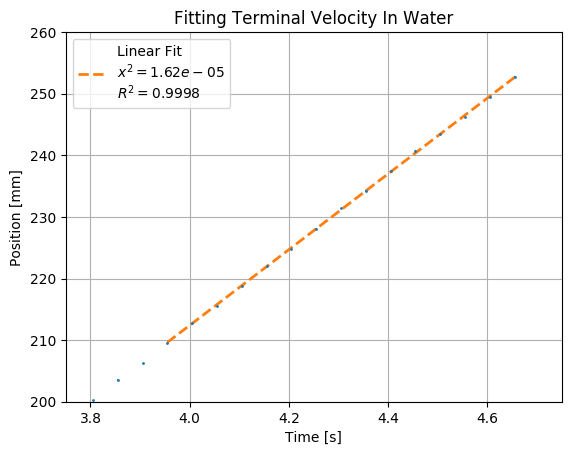

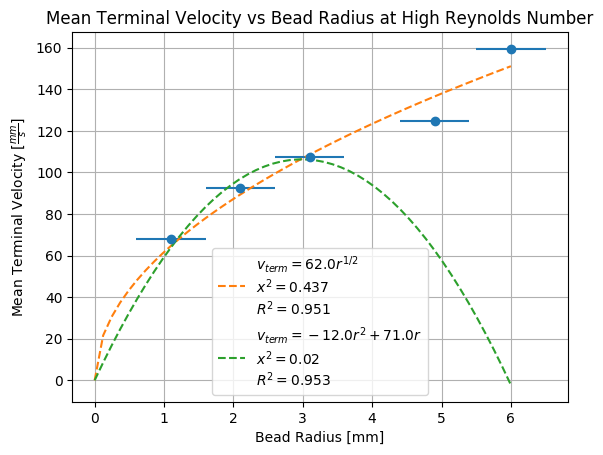

In [7]:
# Ex.2: High Reynolds Number
# data
files = []
for i in range(1, 6):
    filePrefix = "wg"+str(i)+"-t"
    for j in range(1, 6):
        file = filePrefix + str(j)+".txt"
        files.append(file)
    # import files
data = {}
for file in files:
    # print(file)
    key = file[:-4]
    npdata = import_data(file)
    while npdata[1, INDEX_POS] == 0:
        npdata = np.delete(npdata, 0, 0)
    while npdata[-1, INDEX_POS] == 0:
        npdata = np.delete(npdata, -1, 0)
    pyData = []
    for rows in npdata:  # change to lists with uncerts
        newRow = [convert_to_ufloat(rows[INDEX_TIME], UNCERTAINTY_TIME), convert_to_ufloat(rows[INDEX_POS], UNCERTAINTY_POS)]
        pyData.append(newRow)
    data[key] = pyData

# fitting + mean terminals
terminals = {}  # avg terminals
dataFits = {}  # slopes (terminal velocities) and intercepts
dig = 1  # 1 to 5
averages = []  # temp-memory array
fromBack = 15  # amount of last points
for key, value in data.items():
    interest = value[len(value)-fromBack:len(value)]
    time_nom = [row[INDEX_TIME].nominal_value for row in interest]
    pos_nom = [row[INDEX_POS].nominal_value for row in interest]
    coeffs, cov = np.polyfit(time_nom, pos_nom, deg=1, full=False, cov=True)
    a_uncert = np.sqrt(cov[0,0])  # mm/s
    b_uncert = np.sqrt(cov[1, 1])  # s
    res = [convert_to_ufloat(coeffs[0], a_uncert), convert_to_ufloat(coeffs[1], b_uncert)]
    if (dig % 5) == 0 :  # gg[]-..
        terminals[dig//5] = vcorrected(mean(averages), BEAD_SIZES[dig//5 - 1])
        terminals[dig//5] = mean(averages)
        averages = []
    else:
        averages.append(res[0])
    dig += 1
    dataFits[key] = res

# plotting process
example1 = "wg1-t5"
time_nom = [row[INDEX_TIME].nominal_value for row in data[example1]]
pos_nom = [row[INDEX_POS].nominal_value for row in data[example1]]
time_uncert = [row[INDEX_TIME].std_dev for row in data[example1]]
pos_uncert = [row[INDEX_POS].std_dev for row in data[example1]]
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.grid(True)
ax1.set_title("Fitting Terminal Velocity In Water")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Position [mm]")
ax1.errorbar(time_nom, pos_nom,time_uncert, pos_uncert, "o", markersize=1)

    # fitted
fitCoeffs, fitCoeffs_uncert = seperate_ufloat(dataFits[example1])
p = np.poly1d(fitCoeffs)
min_nom = min(time_nom[len(time_nom)-fromBack:len(time_nom)])
max_nom = max(time_nom[len(time_nom)-fromBack:len(time_nom)])

xMin = 3.75
xMax = 4.75
yMin = 200
yMax = 260
ax1.set_xlim([xMin, xMax])
ax1.set_ylim([yMin, yMax])
xp = np.linspace(min_nom, max_nom)
ax1.plot(xp, p(xp), "--", linewidth=2)

x2 = chi_squared(time_nom[len(time_nom)-fromBack:len(time_nom)], pos_nom[len(time_nom)-fromBack:len(time_nom)], p)
r2 = coeff_of_determination(time_nom[len(time_nom)-fromBack:len(time_nom)], pos_nom[len(time_nom)-fromBack:len(time_nom)], p)

ax1.legend(["Linear Fit\n$x^2={}$\n$R^2={}$".format(round_sig(x2, 3), round_sig(r2, 4))])

# print("Chi: {}, R^2: {}".format(round_sig(x2, 3), round_sig(r2, 3)))


print("Slope: {} [m/s]".format(dataFits[example1][0]))

#export
export_plot(fig, "ex2_fitting_terminal_points")

# plotting
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(True)
ax.set_title("Mean Terminal Velocity vs Bead Radius at High Reynolds Number")
ax.set_xlabel("Bead Radius [mm]")
ax.set_ylabel("Mean Terminal Velocity $[\\frac{mm}{s}]$")

# gen data
bead_nom, bead_uncert = seperate_ufloat(BEAD_SIZES)
v_nom, v_uncert = [], []
for i in terminals:
    e = terminals[i]
    v_nom.append(e.nominal_value)
    v_uncert.append(e.std_dev)
ax.errorbar(bead_nom, v_nom, v_uncert, bead_uncert, "o")  # main plot

    # fitting
def bRoot(x, b):
    return b * x**(1/2)
fit, covar = opt.curve_fit(bRoot, bead_nom, v_nom)
xp = np.linspace(0, max(bead_nom))
b = fit[0]
print("b is: {}+/-{}".format(b, np.sqrt(covar)))
    # gen vals
vals = []
for i in xp:
    vals.append(bRoot(i, b))
ax.plot(xp, vals, "--")  # root fit

x2 = chi_squared(bead_nom, v_nom, lambda x: bRoot(x, b))
r2 = coeff_of_determination(bead_nom, v_nom, lambda x: bRoot(x, b))

###########
    # fitting
def cdFit(x, c, d):
    return c * x**(2) + d * x
fit, covar = opt.curve_fit(cdFit, bead_nom[:3], v_nom[:3])
xp = np.linspace(0, max(bead_nom))
c = fit[0]
d = fit[1]
print("c is: {}+/-{}".format(c, np.sqrt(covar[0,0])))
print("d is: {}+/-{}".format(d, np.sqrt(covar[1,1])))
    # gen vals
vals = []
for i in xp:
    vals.append(cdFit(i, c, d))
ax.plot(xp, vals, "--")

x22 = chi_squared(bead_nom[:3], v_nom[:3], lambda x: cdFit(x, c, d))
r22 = coeff_of_determination(bead_nom[:3], v_nom[:3], lambda x: cdFit(x, c, d))

ax.legend(["$v_{term}$"+"$ = {}$".format(round_sig(b, 2))+"$r^{1/2}$"+"\n$x^2={}$\n$R^2={}$".format(round_sig(x2, 3), round_sig(r2, 3)), "$v_{term}$"+"$ = {}r^2 + {}r$".format(round_sig(c, 2), round_sig(d, 2))+"\n$x^2={}$\n$R^2={}$".format(round_sig(x22, 3), round_sig(r22, 3))])

##
rens = []
for i in range(len(BEAD_SIZES)):
    diam = 2*BEAD_SIZES[i]
    vs = terminals[i+1]
    rens.append(reynolds_number(DENSITY_H20, diam/10, vs/10, VISCOSITY_H20))
print("Rens: {}".format(rens))

# exports
export_plot(fig, "ex2_mean_vterm_n_beadr")

################
print("terminals ex2:",terminals)